In [1]:
library(tidyverse)
library(cowplot)

bm <- read_tsv("roc.tsv")
params <- gsub("L", "", bm$selection) %>% strsplit("-E", fixed = T)
params <- do.call(rbind, params)
lvls <- c("1e-5","1e-4","1e-3","1e-2","1e-1","1e0","1e1","1e2","1e3","1e4","1e5")
bm <- bm %>%
        mutate(lambda = factor(params[,1], levels = lvls), 
               eta = factor(params[,2], levels = lvls),
               LD = ifelse(LD, "With LD", "Without LD"),
               net = factor(toupper(net), levels = c("GS", "GM", "GI")))

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.1     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Parsed with column specification:
cols(
  .default = col_double(),
  model = col_character(),
  test = col_character(),
  statistic = col_character(),
  selection = col_character(),
  id = col_integer(),
  net = col_character(),
  LD = col_logical(),
  realSnps = col_integer(),
  realGenes = col_integer(),
  realPSnps = col_integer(),
  detectedSnps = col_integer(),
  detectedGenes = col_integer(),
  detectedPGenes = col_integer()
)
See spec(...) for full column spec

In [2]:
colnames(bm)

[1] "Accuracy"            "Kappa"               "AccuracyLower"      
 [4] "AccuracyUpper"       "AccuracyNull"        "AccuracyPValue"     
 [7] "McnemarPValue"       "Sensitivity"         "Specificity"        
[10] "PosPredValue"        "NegPredValue"        "Precision"          
[13] "Recall"              "F1"                  "Prevalence"         
[16] "DetectionRate"       "DetectionPrevalence" "BalancedAccuracy"   
[19] "model"               "time"                "test"               
[22] "statistic"           "selection"           "id"                 
[25] "h2"                  "net"                 "LD"                 
[28] "realSnps"            "realGenes"           "realPSnps"          
[31] "detectedSnps"        "detectedGenes"       "detectedPGenes"     
[34] "lambda"              "eta"

# Precision

## h<sup>2</sup> = 1

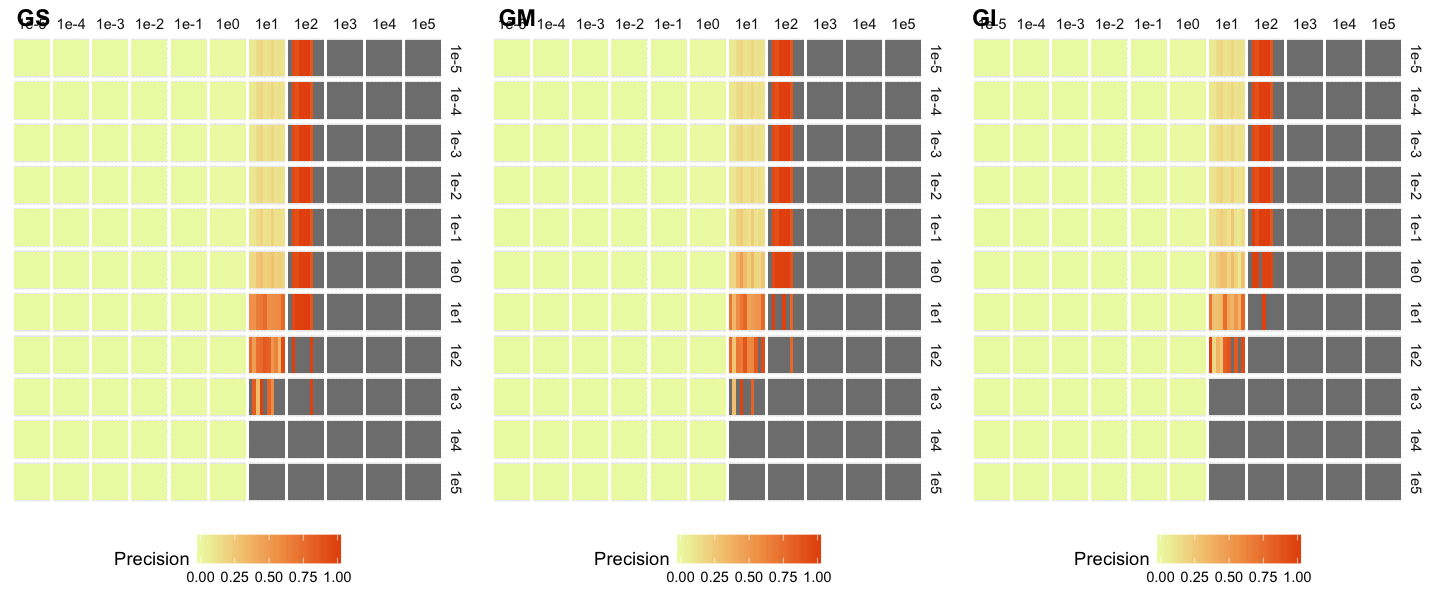

In [3]:
options(repr.plot.width=12, repr.plot.height=5)

plt <- lapply(c("GS","GM","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = as.character(id), y = 1, fill = Precision)) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank(),
              panel.spacing = unit(0.1, "lines")) +
        scale_fill_gradient(limits=c(0,1), low = "#edf8b1", high = "#e6550d")
})

plot_grid(plt[[1]], plt[[2]], plt[[3]], nrow = 1, ncol = 3, labels = c("GS", "GM", "GI"))

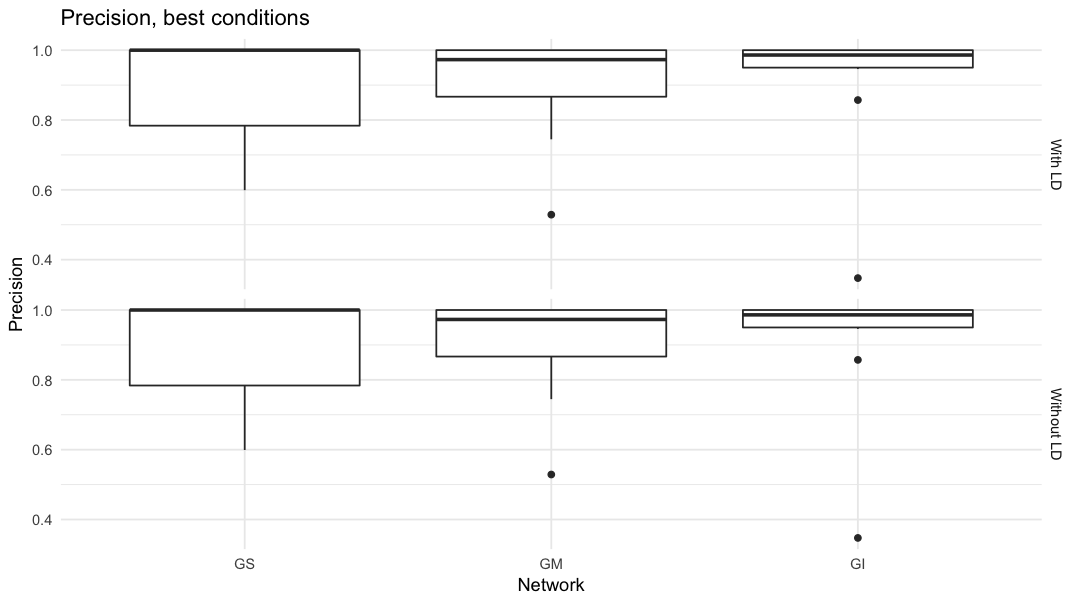

In [4]:
options(repr.plot.width=9, repr.plot.height=5)
bm %>%
    filter(h2 == 1) %>%
    group_by(LD, net, id) %>%
    summarize(Precision = Precision[which.max(Precision)]) %>%
    ggplot(aes(x = net, y = Precision)) +
        geom_boxplot() +
        facet_grid(LD ~ .) +
        theme_minimal() +
        theme(legend.position="bottom") +
        labs(title = "Precision, best conditions", x = "Network")

## h<sup>2</sup> = 0.25

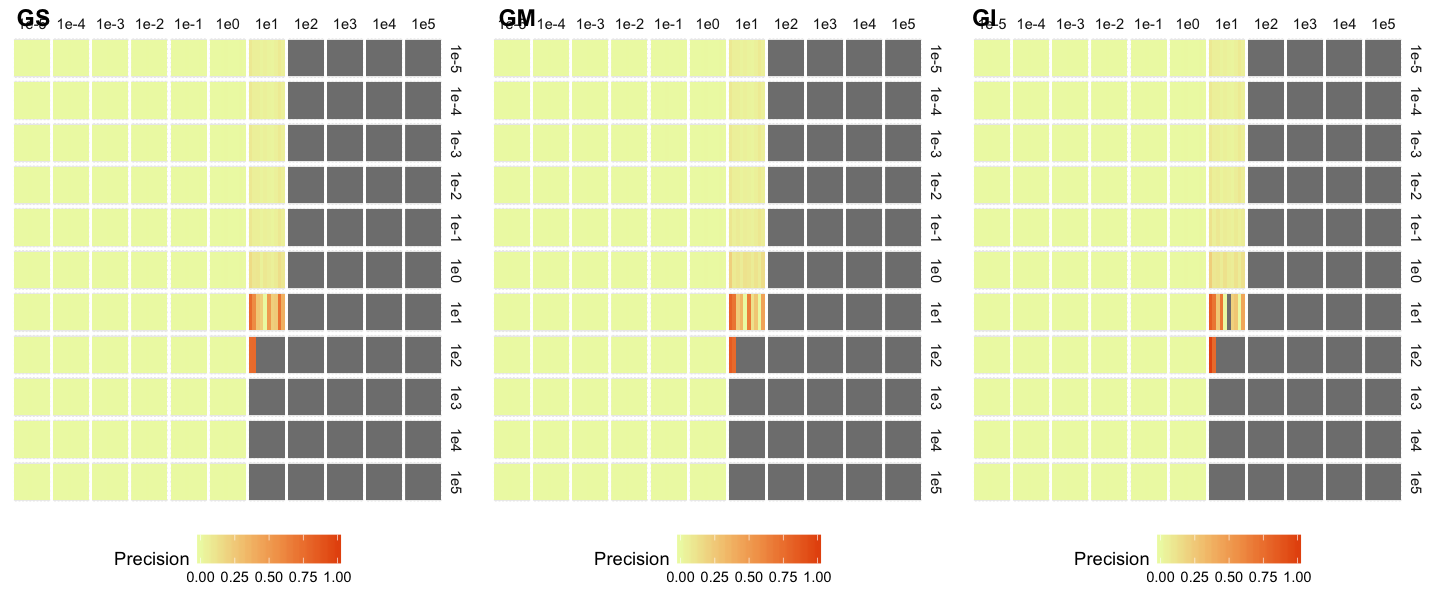

In [5]:
options(repr.plot.width=12, repr.plot.height=5)

plt <- lapply(c("GS","GM","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD" & h2 == 0.25) %>%
    ggplot(aes(x = as.character(id), y = 1, fill = Precision)) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank(),
              panel.spacing = unit(0.1, "lines")) +
        scale_fill_gradient(limits=c(0,1), low = "#edf8b1", high = "#e6550d")
})

plot_grid(plt[[1]], plt[[2]], plt[[3]], nrow = 1, ncol = 3, labels = c("GS", "GM", "GI"))

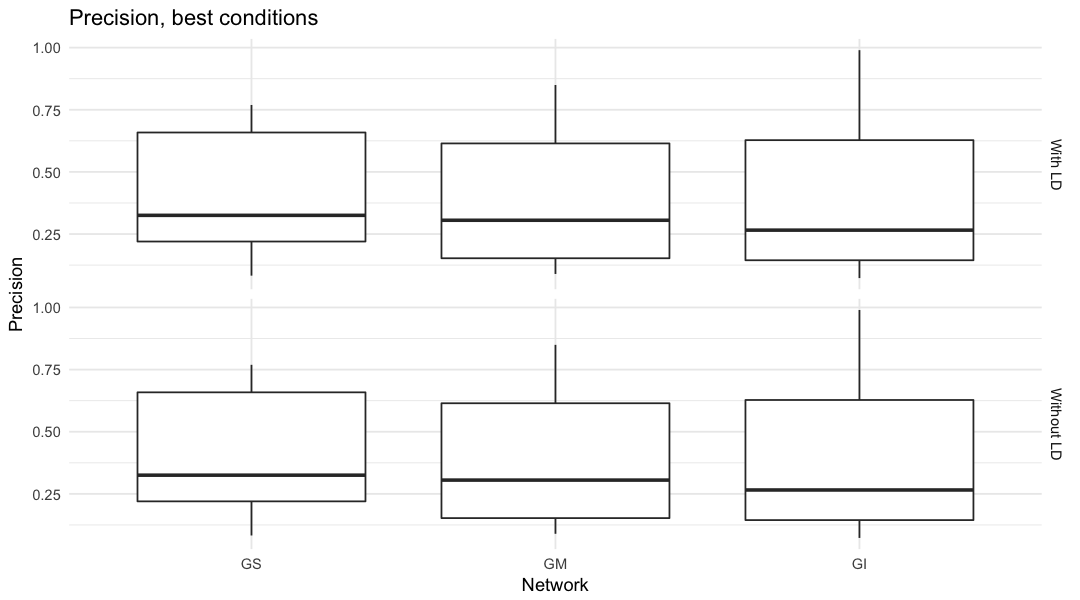

In [6]:
options(repr.plot.width=9, repr.plot.height=5)
bm %>%
    filter(h2 == 0.25) %>%
    group_by(LD, net, id) %>%
    summarize(Precision = Precision[which.max(Precision)]) %>%
    ggplot(aes(x = net, y = Precision)) +
        geom_boxplot() +
        facet_grid(LD ~ .) +
        theme_minimal() +
        theme(legend.position="bottom") +
        labs(title = "Precision, best conditions", x = "Network")

# Ratio detected to causal SNPs

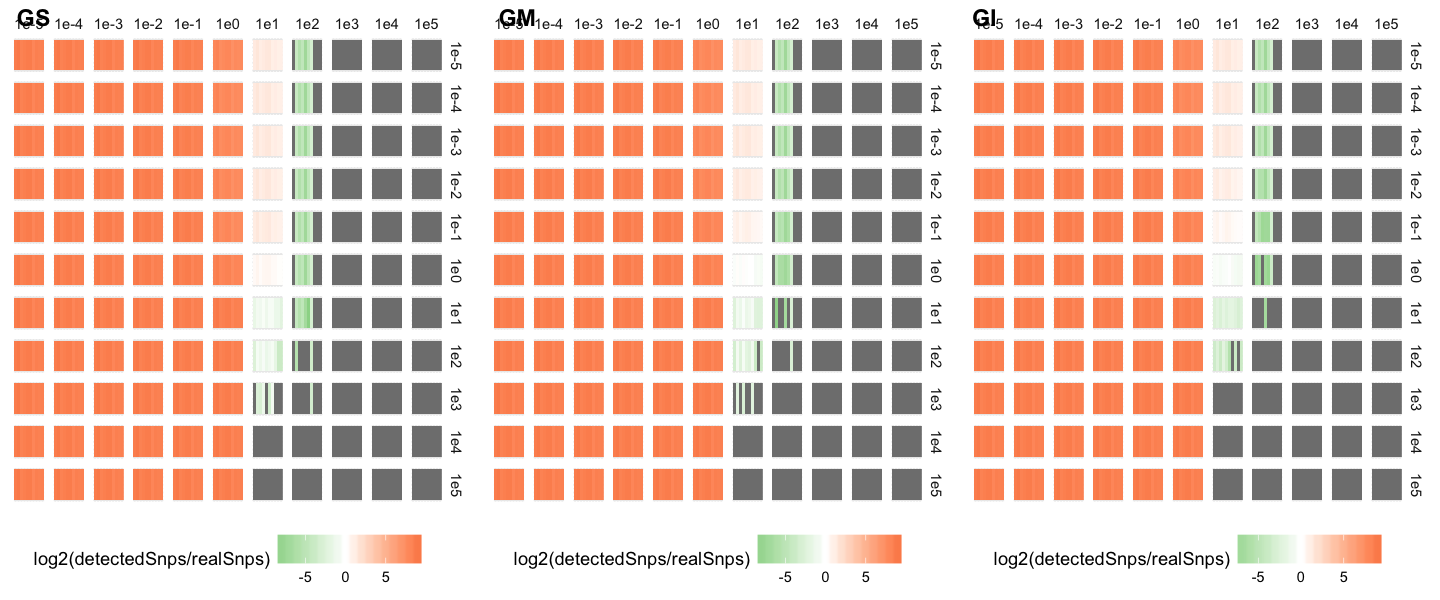

In [7]:
options(repr.plot.width=12, repr.plot.height=5)

plt <- lapply(c("GS","GM","GI"), function(n) {
    filter(bm, net == n  & LD == "Without LD" & h2 == 1) %>%
    ggplot(aes(x = as.character(id), y = 1, fill = log2(detectedSnps/realSnps)) ) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank()) +
        scale_fill_gradient2(low = "#99d594", high = "#fc8d59", mid = "white")
})

plot_grid(plt[[1]], plt[[2]], plt[[3]], nrow = 1, ncol = 3, 
          labels = c("GS", "GM", "GI"))

# Elapsed time

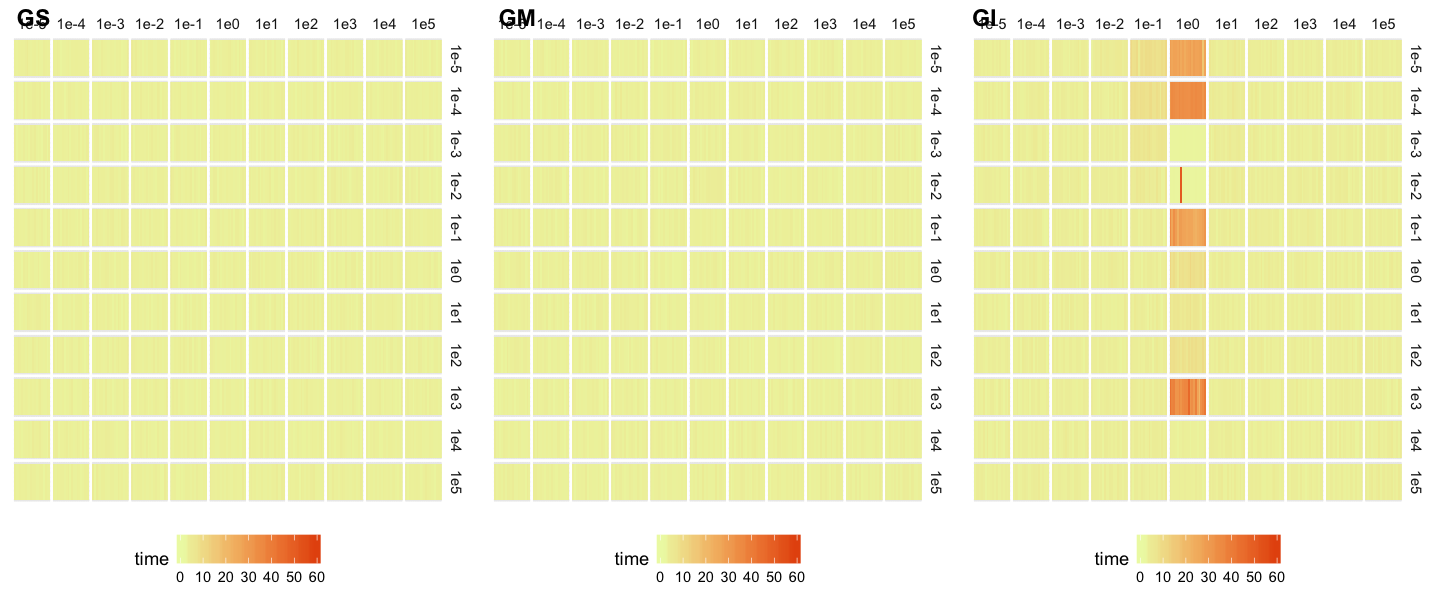

In [8]:
options(repr.plot.width=12, repr.plot.height=5)

plt <- lapply(c("GS","GM","GI"), function(n) {
    filter(bm, net == n & LD == "Without LD") %>%
    ggplot(aes(x = as.character(id), y = 1, fill = time)) +
        geom_tile() +
        facet_grid(lambda ~ eta) +
        theme_minimal() +
        theme(legend.position="bottom",
              axis.title.x=element_blank(), axis.title.y=element_blank(),
              axis.text.x=element_blank(), axis.text.y=element_blank(),
              axis.ticks.x=element_blank(), axis.ticks.y=element_blank(),
              panel.spacing = unit(0.1, "lines")) +
        scale_fill_gradient(limits=c(0,60), low = "#edf8b1", high = "#e6550d")
})

plot_grid(plt[[1]], plt[[2]], plt[[3]], nrow = 1, ncol = 3, labels = c("GS", "GM", "GI"))